Downloading...
From (original): https://drive.google.com/uc?id=1Fn-mc8g_JKOyBw7BuK6ENwT7lL8F6lrM
From (redirected): https://drive.google.com/uc?id=1Fn-mc8g_JKOyBw7BuK6ENwT7lL8F6lrM&confirm=t&uuid=334aacf2-7125-42c1-92be-256e82a72f17
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 112MB/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Training on Node 1
Epoch 1, Loss: 157.5410
Epoch 2, Loss: 81.5132
Epoch 3, Loss: 60.0073
Epoch 4, Loss: 48.6890
Epoch 5, Loss: 42.3216
Node 1 Accuracy: 0.988
Training on Node 2
Epoch 1, Loss: 152.9274
Epoch 2, Loss: 82.1150
Epoch 3, Loss: 60.4721
Epoch 4, Loss: 50.4892
Epoch 5, Loss: 42.6200
Node 2 Accuracy: 0.987
Training on Node 3
Epoch 1, Loss: 154.2467
Epoch 2, Loss: 82.7579
Epoch 3, Loss: 61.4602
Epoch 4, Loss: 50.1672
Epoch 5, Loss: 42.0020
Node 3 Accuracy: 0.986
Training on Node 4
Epoch 1, Loss: 155.3119
Epoch 2, Loss: 82.4059
Epoch 3, Loss: 62.6742
Epoch 4, Loss: 50.6806
Epoch 5, Loss: 43.9228
Node 4 Accuracy: 0.987
Encrypting state for SMPC using symmetric encryption...
Decrypting aggregated state using symmetric encryption...
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56863
           1       0.91      0.86      0.88     56863

    accuracy                           0.89    113726
   macro avg 

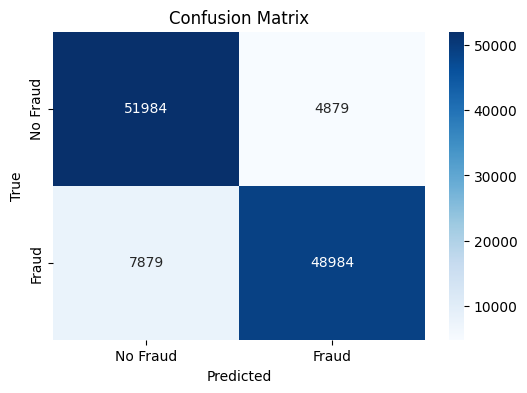

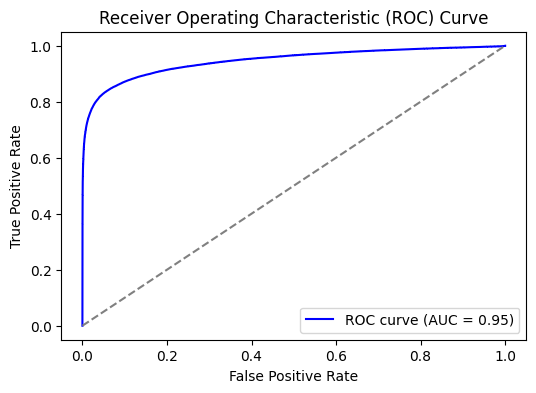

Final Model Accuracy: 0.888
Final ROC AUC Score: 0.946


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, TensorDataset

# Install and import gdown for data download
!pip install gdown
import gdown

# ---------------------------
# 1. Data Loading & Preprocessing
# ---------------------------

# File ID extracted from the Google Drive link
file_url = "https://drive.google.com/uc?id=1Fn-mc8g_JKOyBw7BuK6ENwT7lL8F6lrM"

# Download the file
gdown.download(file_url, 'creditcard.csv', quiet=False)

# Read the CSV file
data = pd.read_csv('creditcard.csv', encoding='ISO-8859-1')
X = data.drop('Class', axis=1)
y = data['Class']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handling Class Imbalance with Oversampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_scaled, y)

# Splitting Data into Training and Testing Sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X_resampled, y_resampled))
X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

# Splitting Training Data into 4 Nodes (simulating a federated scenario)
X_nodes = np.array_split(X_train, 4)
y_nodes = np.array_split(y_train, 4)

# ---------------------------
# 2. Defining the Neural Network Model
# ---------------------------
class FraudDetectionModel(nn.Module):
    def __init__(self, input_size):
        super(FraudDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)

        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

# ---------------------------
# 3. Training Models on Each Node (Federated Setup)
# ---------------------------
models = []
accuracies = []

for i, (X_node, y_node) in enumerate(zip(X_nodes, y_nodes)):
    print(f"Training on Node {i+1}")

    # Convert node data to tensors
    X_tensor = torch.FloatTensor(X_node)
    y_tensor = torch.FloatTensor(y_node.values.reshape(-1, 1))
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

    # Initialize the model for this node
    model = FraudDetectionModel(X_tensor.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train for 5 epochs
    for epoch in range(5):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    # Evaluate on node training data
    y_pred = model(X_tensor).detach().numpy()
    y_pred = (y_pred > 0.5).astype(int)
    acc = accuracy_score(y_node, y_pred)
    print(f"Node {i+1} Accuracy: {acc:.3f}")
    accuracies.append(acc)
    models.append(model)

# ---------------------------
# 4. Simple SMPC & Differential Privacy Abstractions
# ---------------------------

# We'll use a fixed symmetric key for our simple XOR-based encryption.
SYMMETRIC_KEY = b'secretkey'

def xor_encrypt(data: bytes, key: bytes) -> bytes:
    """
    Simple XOR encryption using numpy.
    """
    data_arr = np.frombuffer(data, dtype=np.uint8)
    key_arr = np.frombuffer(key, dtype=np.uint8)
    # Repeat key to match data length
    repeated_key = np.resize(key_arr, data_arr.shape)
    encrypted = np.bitwise_xor(data_arr, repeated_key)
    return encrypted.tobytes()

def simple_symmetric_encrypt(tensor: torch.Tensor, key: bytes):
    """
    Encrypts a tensor by converting it to bytes and applying XOR encryption.
    Returns a tuple: (shape, dtype, encrypted_bytes)
    """
    np_array = tensor.cpu().numpy()
    data_bytes = np_array.tobytes()
    encrypted_bytes = xor_encrypt(data_bytes, key)
    return (np_array.shape, str(np_array.dtype), encrypted_bytes)

def simple_symmetric_decrypt(encrypted_tuple, key: bytes):
    """
    Decrypts the encrypted tuple to reconstruct the original tensor.
    """
    shape, dtype_str, encrypted_bytes = encrypted_tuple
    decrypted_bytes = xor_encrypt(encrypted_bytes, key)  # XOR is reversible
    np_array = np.frombuffer(decrypted_bytes, dtype=np.dtype(dtype_str))
    np_array = np_array.reshape(shape)
    return torch.tensor(np_array)

def dummy_encrypt(state):
    """
    Simulate SMPC encryption using a simple symmetric encryption.
    Encrypts each tensor in the state.
    """
    print("Encrypting state for SMPC using symmetric encryption...")
    encrypted_state = {}
    for key, tensor in state.items():
        encrypted_state[key] = simple_symmetric_encrypt(tensor, SYMMETRIC_KEY)
    return encrypted_state

def dummy_decrypt(state):
    """
    Simulate SMPC decryption using a simple symmetric encryption.
    Decrypts each encrypted tensor tuple.
    """
    print("Decrypting aggregated state using symmetric encryption...")
    decrypted_state = {}
    for key, encrypted_tuple in state.items():
        decrypted_state[key] = simple_symmetric_decrypt(encrypted_tuple, SYMMETRIC_KEY)
    return decrypted_state

def apply_differential_privacy(state, epsilon=100.0):
    """
    Apply simple differential privacy by adding Gaussian noise.
    The noise scale is controlled by 'epsilon' (higher epsilon means less noise).
    """
    dp_state = {}
    for key, value in state.items():
        noise = torch.randn(value.size()) / epsilon  # Adjust scale as needed
        dp_state[key] = value + noise
    return dp_state

def federated_avg_dp_smpc(models, dp_epsilon=100.0):
    """
    Simulates secure aggregation (SMPC) with differential privacy.
    For each node, the state is first perturbed with DP noise.
    Then the plain DP states are aggregated, and the aggregated state is encrypted and then decrypted.
    """
    aggregated_state = None
    for i, model in enumerate(models):
        state = model.state_dict()
        # Apply differential privacy (add noise)
        dp_state = apply_differential_privacy(state, epsilon=dp_epsilon)
        if i == 0:
            aggregated_state = {key: dp_state[key].clone() for key in dp_state}
        else:
            for key in dp_state:
                aggregated_state[key] += dp_state[key]
    # Average the aggregated state
    for key in aggregated_state:
        aggregated_state[key] /= len(models)
    # Encrypt the aggregated state (simulate SMPC encryption)
    encrypted_aggregated_state = dummy_encrypt(aggregated_state)
    # Decrypt the aggregated state (simulate SMPC decryption)
    decrypted_state = dummy_decrypt(encrypted_aggregated_state)
    avg_model = FraudDetectionModel(X_resampled.shape[1])
    avg_model.load_state_dict(decrypted_state)
    return avg_model

# ---------------------------
# 5. Aggregating Models using the SMPC + DP Abstraction
# ---------------------------
final_model = federated_avg_dp_smpc(models, dp_epsilon=100.0)

# ---------------------------
# 6. Evaluating the Final Aggregated Model
# ---------------------------
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1))

y_probs = final_model(X_test_tensor).detach().numpy()
y_preds = (y_probs > 0.5).astype(int)

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(y_test, y_preds))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_preds)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fraud', 'Fraud'], yticklabels=['No Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

print(f"Final Model Accuracy: {accuracy_score(y_test, y_preds):.3f}")
print(f"Final ROC AUC Score: {roc_auc:.3f}")
